# Simple scanning simulations

We want to use this notebook to look at the effects of a non-ideal half-wave plate on a simple scanning simulation. Let's start by loading up some modules that are needed for the analysis. 

In [1]:
import numpy as np
import healpy as hp
from beamconv import ScanStrategy
import matplotlib
import matplotlib.pyplot as plt


In [2]:
import qpoint as qp
print(qp.__file__)

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/qpoint/__init__.pyc


Before starting the scanning simulation, we need to invoke some model of the underlying sky. For this example, we describe the sky as statistically isotropic and Gaussian I, Q, and U fields (with underlying power spectra and correlations as determined in the WMAP 7-year release).

In [3]:
#cls = np.zeros((5,2700))
#cls[0,:] = np.arange(2700, dtype=np.int16)
cls = np.loadtxt('../ancillary/wmap7_r0p03_lensed_uK_ext.txt',
                 unpack=True) # Cl in uK^2
lmax=700 
ell, cls = cls[0], cls[1:]
np.random.seed(25) 
alm = hp.synalm(cls, lmax=lmax, new=True, verbose=True) # uK

Here we set parameters that describe the pointing, the instrument and the beams. For this example, we just pick identical symmetric Gaussian beams with no cross-polarization. This will later allow us to easily check whether the code reproduces this known case.

In [17]:
fwhm = 40
beam_opts = dict(lmax=lmax,
                 fwhm=fwhm,       # Gaussian co-pol beam, so only specify FWHM (arcmin)
                 btype='Gaussian')

spin_opts = dict(max_spin=2,      # Symmetric beams, so 2 is sufficient
                 nside_spin=256)  # nside of scanned maps 

scan_opts = dict(ra0=[-10],       # Center of scan
                 dec0=[-57.5],
                 az_throw=5,     # Scan width
                 scan_speed=1)

mlen        = 24 * 60 * 60        # Mission length in seconds
rot_period  = 6 * 60 * 60
step_period = 1.5 * 60 * 60

An seasoned experimentalist might notice that we are defining scan regions and parameters that are not very dissimilar from that of the BICEP class of experiments. These experiments scan around 1-2% of the sky. Now that we have defined some of the boundary conditions of our experiment, we can start initializing scan strategy objects.

In [18]:
bideal = ScanStrategy(duration=mlen,
                  sample_rate=12.01, # sample rate in Hz
                  location='spole')  # Instrument at south pole (preset)
bnideal = ScanStrategy(duration=mlen,
                  sample_rate=12.01, # sample rate in Hz
                  location='spole')  # Instrument at south pole (preset)

# Create a 3 x 3 square grid of Gaussian beams (f.o.v. is 3 degrees)
bideal.create_focal_plane(nrow=3, ncol=3, fov=3, no_pairs=True,**beam_opts)
bnideal.create_focal_plane(nrow=3, ncol=3, fov=3, no_pairs=True,**beam_opts)

# Calculate tods in two chunks
chunks = bideal.partition_mission(0.5*bideal.mlen*bideal.fsamp) 
nideal_chunks = bnideal.partition_mission(0.5*bnideal.mlen*bnideal.fsamp) 
# Allocate and assign parameters for mapmaking
bideal.allocate_maps(nside=256)
bnideal.allocate_maps(nside=256)
# Set instrument rotation
bideal.set_instr_rot(period=rot_period, angles=[0,30, 60, 90, 60, 30, 0])
bnideal.set_instr_rot(period=rot_period, angles=[0,30, 60, 90, 60, 30, 0])
# Set elevation stepping
bideal.set_el_steps(step_period, steps=[-4,-3,-2,-1,0,1,2,3,4])
bnideal.set_el_steps(step_period, steps=[-4,-3,-2,-1,0,1,2,3,4])
# Set HWP modulation
bideal.set_hwp_mod(mode='continuous', freq=1.)#mode='continuous'
bnideal.set_hwp_mod(mode='continuous', freq=1.)#mode='continuous'

Here we actually scan the sky. We also solve for the I, Q and U maps and calculate the condition number of the per-pixel projection matrix. This might take a minute on a single core. Notice that the half-wave plate's argument accepts two values, 'ideal' and 'non-ideal'. Other values will raise a ValueError() Default is ideal.

In [19]:
# Generate timestreams, bin them and store as attributes
bideal.scan_instrument_mpi(alm, hwp_status='ideal', **scan_opts)
# Solve for the maps
ideal_maps, ideal_cond = bideal.solve_for_map()
bnideal.scan_instrument_mpi(alm, hwp_status='non-ideal', **scan_opts)
maps, cond = bnideal.solve_for_map()

Scanning with 2 detectors
[rank 000]: working on: r000c000A, r000c000B
[rank 000]:	Working on chunk 000: samples 0-518832
[rank 000]:	Working on chunk 001: samples 518832-1037664
Scanning with 2 detectors
[rank 000]: working on: r000c000A, r000c000B
[rank 000]:	Working on chunk 000: samples 0-518832
[rank 000]:	Working on chunk 001: samples 518832-1037664


# Results

With the data generated and binned into maps, we can visualize the results. We plot the condition number map and the solved I, Q and U maps. We expect the condition number to be as low as possible (=2) for almost all pixels because of the continuous HWP rotation and the instrument rotation. We can see the differences between the non-ideal HWP model (top row) and the ideal one (bottom row).

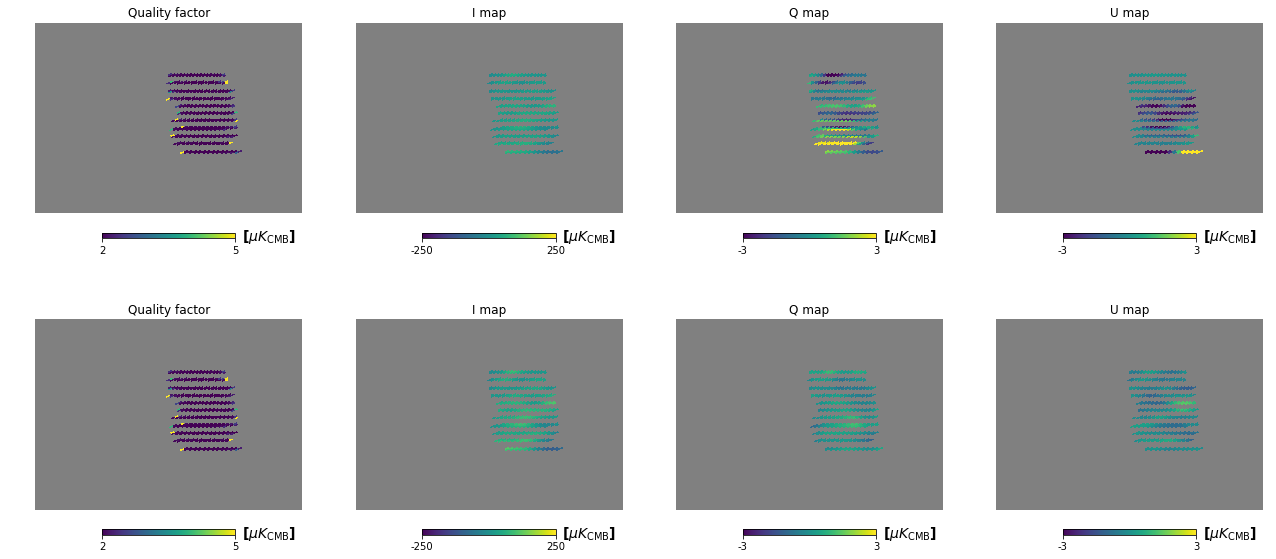

In [20]:
cond[cond == np.inf] = hp.UNSEEN
cart_opts = dict(unit=r'[$\mu K_{\mathrm{CMB}}$]', lonra=[-25, 10], latra=[-70, -45], hold=True)
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(22, 10))
plt.axes(axs[0,0])
hp.cartview(cond, min=2, max=5, title='Quality factor', **cart_opts)
plt.axes(axs[0,1])
hp.cartview(maps[0], min=-250, max=250, title='I map', **cart_opts)
plt.axes(axs[0,2])
hp.cartview(maps[1], min=-3, max=3, title='Q map', **cart_opts)
plt.axes(axs[0,3])
hp.cartview(maps[2], min=-3, max=3, title='U map', **cart_opts)
ideal_cond[ideal_cond == np.inf] = hp.UNSEEN
plt.axes(axs[1,0])
hp.cartview(ideal_cond, min=2, max=5, title='Quality factor', **cart_opts)
plt.axes(axs[1,1])
hp.cartview(ideal_maps[0], min=-250, max=250, title='I map', **cart_opts)
plt.axes(axs[1,2])
hp.cartview(ideal_maps[1], min=-3, max=3, title='Q map', **cart_opts)
plt.axes(axs[1,3])
hp.cartview(ideal_maps[2], min=-3, max=3, title='U map', **cart_opts)

We can see leakeage between I and Q/U in the non-ideal map (usually) compared to the ideal HWP case. 

Finally, we can check the results by comparing them to the smoothed input map by plotting difference maps.

In [23]:
hp.smoothalm(alm, fwhm=np.radians(fwhm / 60.))
sm_in = hp.alm2map(alm, hp.get_nside(maps[0]))
diff = maps - sm_in
ideal_diff = ideal_maps - sm_in

Sigma is 16.986436 arcmin (0.004941 rad) 
-> fwhm is 40.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


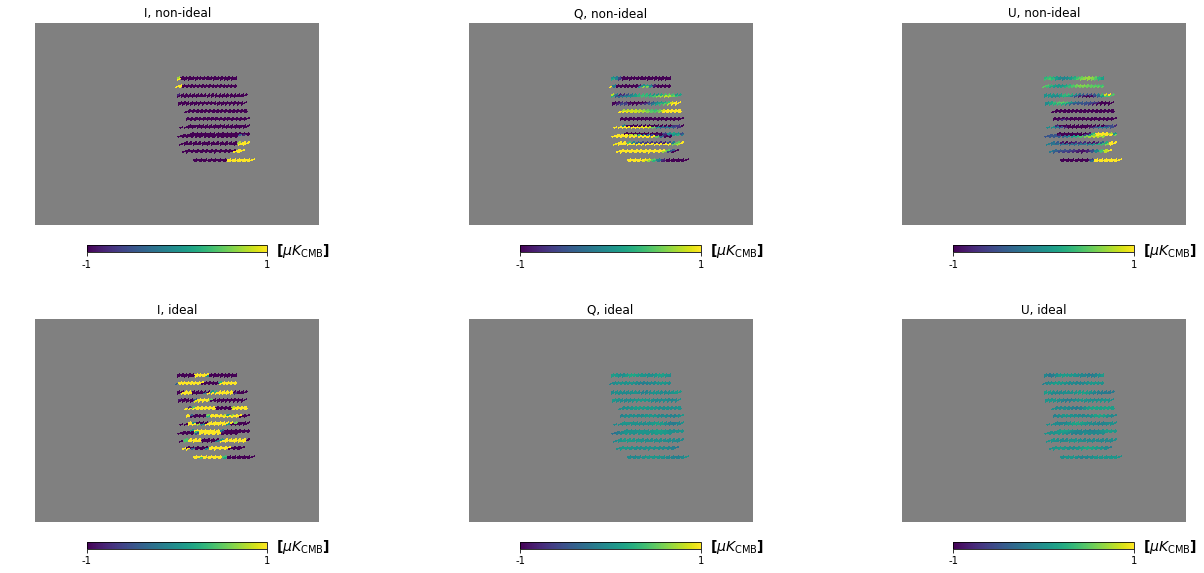

In [26]:
fig2, axs2 = plt.subplots(ncols=3, nrows=2, figsize=(22, 10))
plt.axes(axs2[0,0])
hp.cartview(diff[0], min=-1, max=1, title='I, non-ideal', **cart_opts)
plt.axes(axs2[0,1])
hp.cartview(diff[1], min=-1, max=1, title='Q, non-ideal', **cart_opts)
plt.axes(axs2[0,2])
hp.cartview(diff[2], min=-1, max=1, title='U, non-ideal', **cart_opts)
plt.axes(axs2[1,0])
hp.cartview(ideal_diff[0], min=-1, max=1, title='I, ideal', **cart_opts)
plt.axes(axs2[1,1])
hp.cartview(ideal_diff[1], min=-1, max=1, title='Q, ideal', **cart_opts)
plt.axes(axs2[1,2])
hp.cartview(ideal_diff[2], min=-1, max=1, title='U, ideal', **cart_opts)

So, up to some Q <-> U leakage at the 1e-10 uK level, we reproduce the expected result for the ideal HWP.


1.6375e+30
